# Reproduction of Fig. S2

ARF stop codon bias for core genes

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD
metadata = Metadata()

In [2]:
bias = pd.read_pickle(path2.data/'marker-genes-Z.pkl.bz2')
Z_stop_all, Z_stop_bac120 = bias['Z_stop_all'], bias['Z_stop_bac120']

In [2]:
# no error
!cat $path2.data/gtdbtk/gtdbtk.failed_genomes.tsv

In [3]:
markers_summary = pd.read_csv(
    path2.data/'gtdbtk'/'gtdbtk.bac120.markers_summary.tsv', 
    sep='\t', index_col=0
)

In [4]:
path2markers = path2.data/'gtdbtk'/'identify'/'intermediate_results'/'marker_genes'

def get_tophits(ncbi_gcf):
    tophits = pd.concat([
        pd.read_csv(path2markers/ncbi_gcf/f'{ncbi_gcf}_pfam_tophit.tsv',sep='\t'),
        pd.read_csv(path2markers/ncbi_gcf/f'{ncbi_gcf}_tigrfam_tophit.tsv',sep='\t')
    ])
    tophits = pd.concat([
        tophits['Gene Id'],
        tophits['Top hits (Family id,e-value,bitscore)'].str.split(',', expand=True),
    ], axis=1).rename({'Gene Id':'gene_id', 0:'family_id', 1:'evalue', 2:'bitscore'}, axis=1).set_index(['family_id', 'gene_id'])
    return tophits


In [5]:
fill_list = lambda d: d if type(d) is list else []
markers_lists = markers_summary['list_unique_genes'].str.split(',').apply(fill_list) + \
               markers_summary['list_multiple_genes'].str.split(',').apply(fill_list) + \
               markers_summary['list_multiple_unique_genes'].str.split(',').apply(fill_list)

For the CDSs annotated by Prodigal inside gtdbtk, we calculated the bias of the ARF stop codon in the same way as in the main analysis, except that overlap was not taken into account.

In [6]:
codon_idx   = [*map(''.join, product('ACGT', repeat=3))]
bicodon_idx = [*map(''.join, product('ACGT', repeat=6))]
 
def count_freqs_markers(ncbi_gcf):
    tophits  = get_tophits(ncbi_gcf)
    families = markers_lists[ncbi_gcf]
    bac120   = set(tophits.loc[families].index.get_level_values(1))
    
    bac120_codons   = pd.DataFrame(index=codon_idx, dtype=pd.Int32Dtype())
    bac120_bicodons = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())
    all_codons   = pd.DataFrame(index=codon_idx, dtype=pd.Int32Dtype())
    all_bicodons = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())
    
    for rec in SeqIO.parse(path2markers/ncbi_gcf/f'{ncbi_gcf}_protein.fna', 'fasta'):
        if rec.id in bac120:
            bac120_codons[rec.id]   = pd.Series(Counter(sliding(str(rec.seq), 3, 3)), dtype=pd.Int32Dtype())
            bac120_bicodons[rec.id] = pd.Series(Counter(sliding(str(rec.seq), 6, 3)), dtype=pd.Int32Dtype())
        all_codons[rec.id]   = pd.Series(Counter(sliding(str(rec.seq), 3, 3)), dtype=pd.Int32Dtype())
        all_bicodons[rec.id] = pd.Series(Counter(sliding(str(rec.seq), 6, 3)), dtype=pd.Int32Dtype())

    return ncbi_gcf[5:], (bac120_codons.T.sum(), bac120_bicodons.T.sum()), (all_codons.T.sum(), all_bicodons.T.sum())


In [7]:
bac120_codons_summary   = pd.DataFrame(index=codon_idx  , dtype=pd.Int32Dtype())
bac120_bicodons_summary = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())
all_codons_summary   = pd.DataFrame(index=codon_idx  , dtype=pd.Int32Dtype())
all_bicodons_summary = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())

from multiprocessing import Pool

with Pool(100) as pool:
    for acc, (bac120_codons, bac120_bicodons), (all_codons, all_bicodons) in tqdm(
        pool.imap_unordered(count_freqs_markers, markers_lists.index),
        total=len(markers_summary)
    ):
        bac120_codons_summary[acc]   = bac120_codons
        bac120_bicodons_summary[acc] = bac120_bicodons
        all_codons_summary[acc]      = all_codons
        all_bicodons_summary[acc]    = all_bicodons
    

  0%|          | 0/2624 [00:00<?, ?it/s]

In [8]:
bac120_codon_usage  = bac120_codons_summary / bac120_codons_summary.groupby(bac_translate).transform('sum')
obs_bac120_bicodons = bac120_bicodons_summary
exp_bac120_bicodons = bac120_bicodons_summary.groupby(bac_translate).transform('sum') \
                       * bac120_bicodons_summary.index.to_series().str[:3].apply(lambda c: bac120_codon_usage.loc[c]) \
                       * bac120_bicodons_summary.index.to_series().str[3:].apply(lambda c: bac120_codon_usage.loc[c])

all_codon_usage  = all_codons_summary / all_codons_summary.groupby(bac_translate).transform('sum')
obs_all_bicodons = all_bicodons_summary
exp_all_bicodons = all_bicodons_summary.groupby(bac_translate).transform('sum') \
                    * all_bicodons_summary.index.to_series().str[:3].apply(lambda c: all_codon_usage.loc[c]) \
                    * all_bicodons_summary.index.to_series().str[3:].apply(lambda c: all_codon_usage.loc[c])

In [9]:
fw1 = lambda bc: bac_translate(bc[1:4])
fw2 = lambda bc: bac_translate(bc[2:5])
rc1 = lambda bc: bac_translate(reverse_complement(bc[1:4]))
rc2 = lambda bc: bac_translate(reverse_complement(bc[2:5]))

In [26]:
Z_stop_bac120, Z_stop_all = pd.DataFrame(dtype=float), pd.DataFrame(dtype=float)
d_stop_bac120, d_stop_all = pd.DataFrame(dtype=float), pd.DataFrame(dtype=float)

for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
    obs_bac120_aa = obs_bac120_bicodons.groupby(arf).sum()
    exp_bac120_aa = exp_bac120_bicodons.groupby(arf).sum()
    assert np.isclose(obs_bac120_aa.sum(), exp_bac120_aa.sum()).all()
    N_bac120 = exp_bac120_aa.sum()
    obs_bac120_stop, exp_bac120_stop = obs_bac120_aa.loc['*'], exp_bac120_aa.loc['*']
    Z_stop_bac120[frame] = (obs_bac120_stop - exp_bac120_stop) / np.sqrt((N_bac120 * exp_bac120_stop - exp_bac120_stop ** 2) / (N_bac120 - 1))
    d_stop_bac120[frame] = (obs_bac120_stop - exp_bac120_stop) / N_bac120
    
    obs_all_aa = obs_all_bicodons.groupby(arf).sum()
    exp_all_aa = exp_all_bicodons.groupby(arf).sum()
    assert np.isclose(obs_all_aa.sum(), exp_all_aa.sum()).all()
    N_all = exp_all_aa.sum()
    obs_all_stop, exp_all_stop = obs_all_aa.loc['*'], exp_all_aa.loc['*']
    Z_stop_all[frame] = (obs_all_stop - exp_all_stop) / np.sqrt((N_all * exp_all_stop - exp_all_stop ** 2) / (N_all - 1))
    d_stop_all[frame] = (obs_all_stop - exp_all_stop) / N_all
    

In [3]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

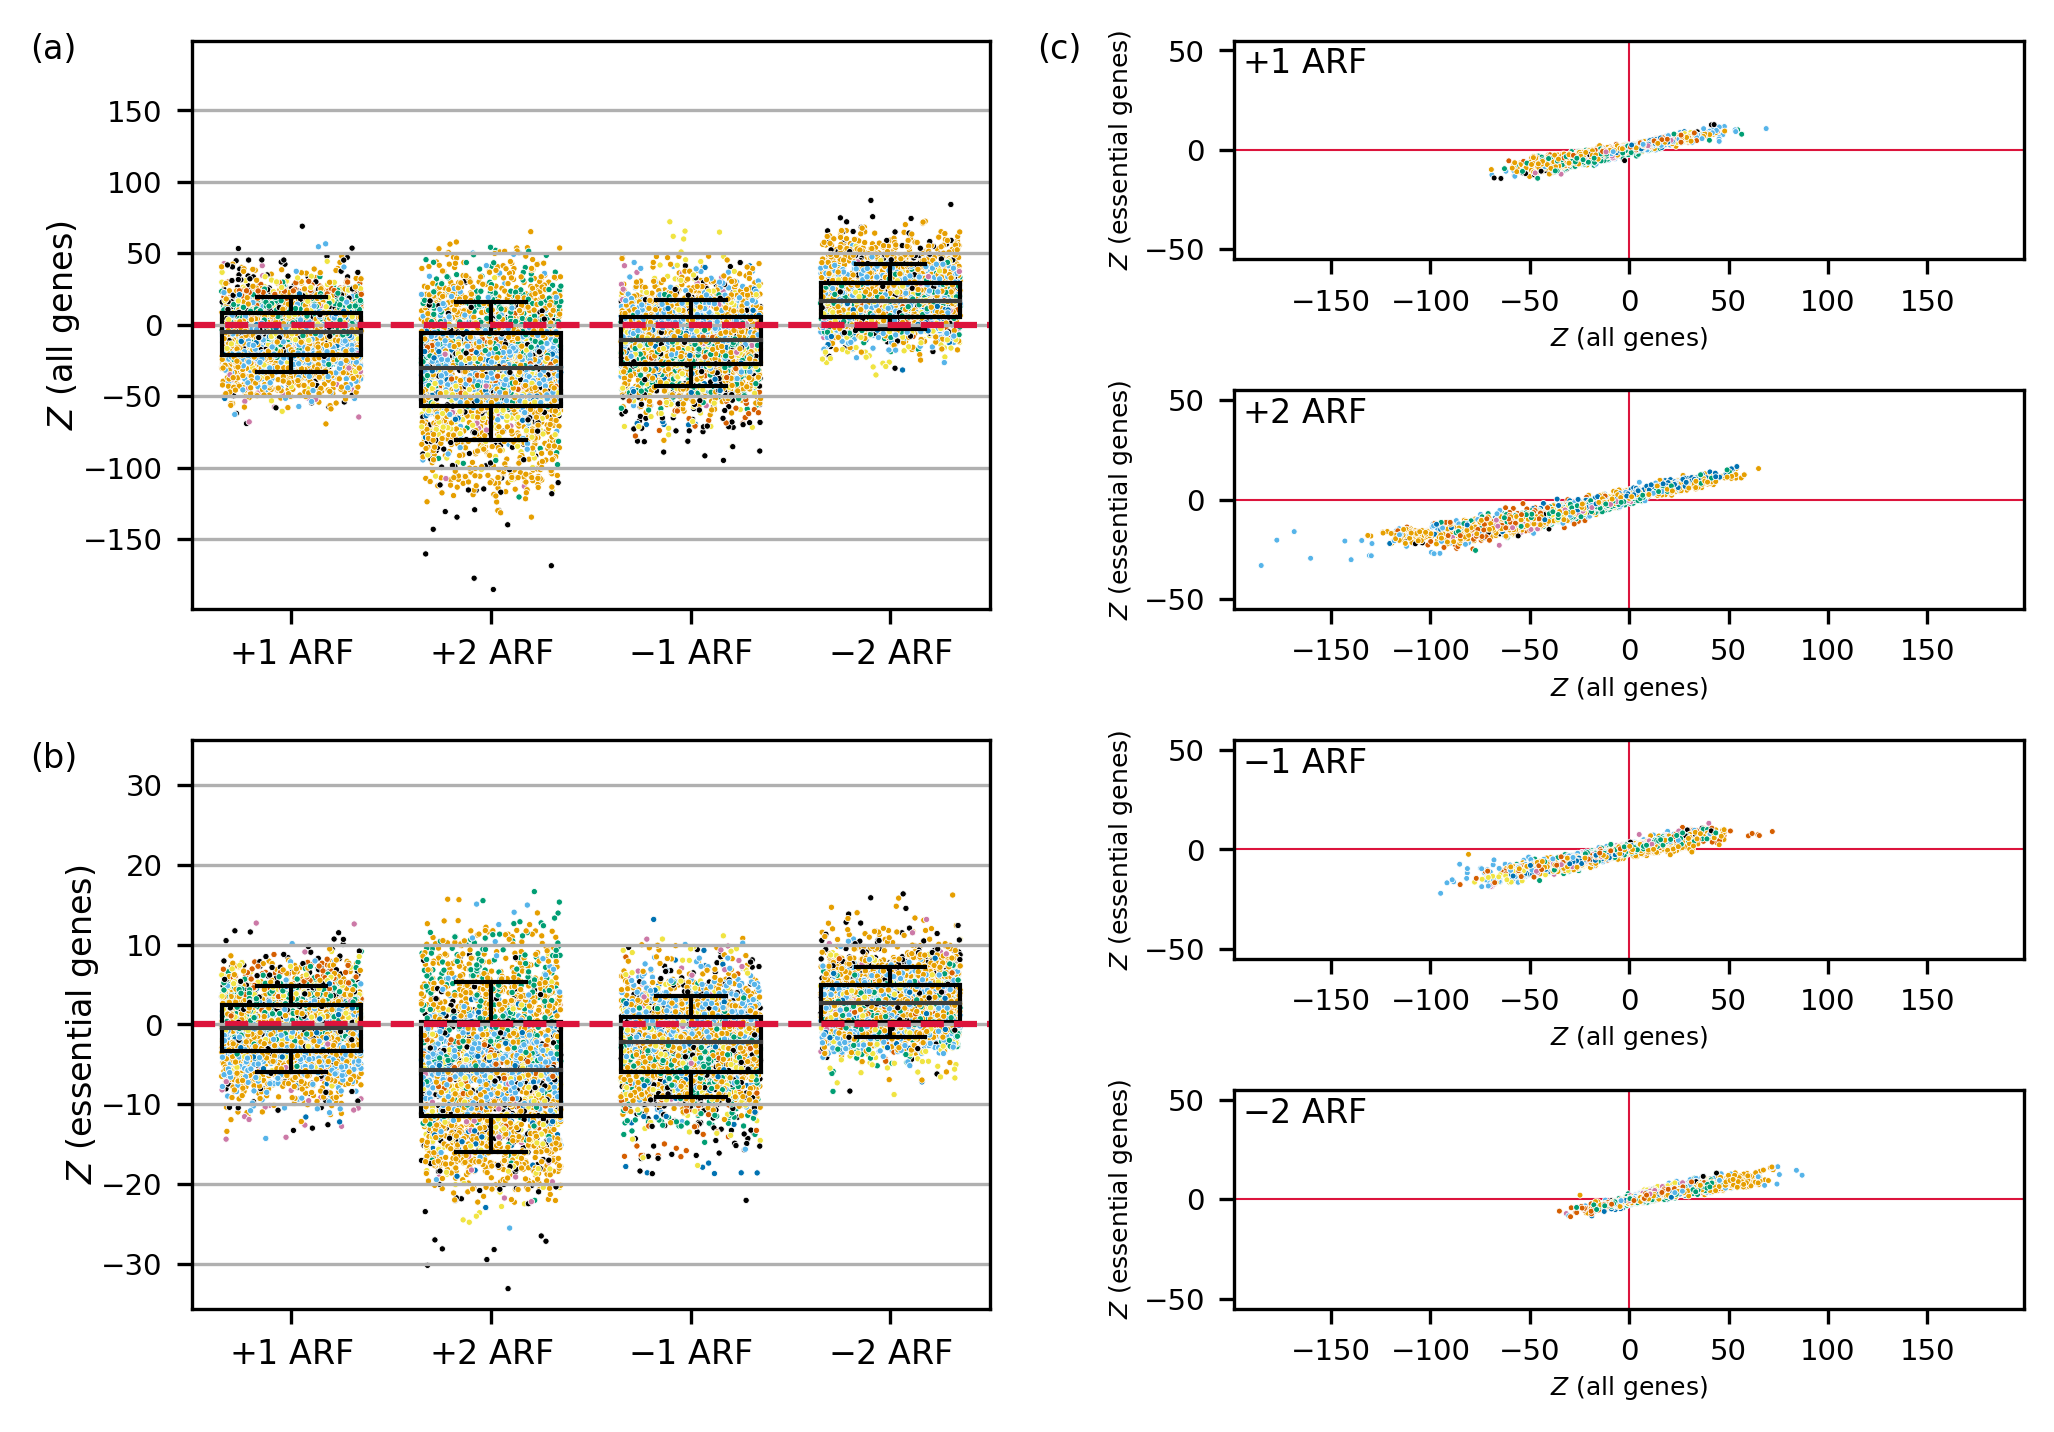

In [7]:
mm = 1 / 25.4
with plt.rc_context({'font.size': 8, 'xtick.labelsize': 7, 'ytick.labelsize': 7}):
    fig = plt.figure(figsize=(174*mm, 120*mm), dpi=300)
    gs = plt.GridSpec(4, 2, figure=fig)#, hspace=0.6, wspace=0.3)
    ax1 = fig.add_subplot(gs[0:2,0])
    ax2 = fig.add_subplot(gs[2:4,0])
    ax3 = fig.add_subplot(gs[0,1])
    ax4 = fig.add_subplot(gs[1,1], sharex=ax3, sharey=ax3)
    ax5 = fig.add_subplot(gs[2,1], sharex=ax3, sharey=ax3)
    ax6 = fig.add_subplot(gs[3,1], sharex=ax3, sharey=ax3)

    pltdata1 = Z_stop_all.stack().rename_axis(['gcf', 'frame']).rename('Z').reset_index()
    pltdata1 = pltdata1.assign(phylum=pltdata1['gcf'].map(refseq2gtdbrep).map(phylum_masked))
    sns.boxplot(
        x='frame', y='Z', data=pltdata1,
        ax=ax1, width=0.7, linewidth=1, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10, 90], fliersize=0
    )
    sns.stripplot(
        x='frame', y='Z', hue='phylum', hue_order=[*top_idx, '(others)'], data=pltdata1, 
        ax=ax1, jitter=0.35, s=1.5, ec='w', linewidth=0.2, zorder=0, palette=CUD.OkabeIto_cpal,
    )    
    pltdata2 = Z_stop_bac120.stack().rename_axis(['gcf', 'frame']).rename('Z').reset_index()
    pltdata2 = pltdata2.assign(phylum=pltdata2['gcf'].map(refseq2gtdbrep).map(phylum_masked))
    sns.boxplot(
        x='frame', y='Z', data=pltdata2,
        ax=ax2, width=0.7, linewidth=1, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10, 90], fliersize=0
    )
    sns.stripplot(
        x='frame', y='Z', hue='phylum', hue_order=[*top_idx, '(others)'], data=pltdata2, 
        ax=ax2, jitter=0.35, s=1.5, ec='w', linewidth=0.2, zorder=0, palette=CUD.OkabeIto_cpal,
    )
    ax1.yaxis.set_major_locator(plt.MultipleLocator(50))
    ax2.yaxis.set_major_locator(plt.MultipleLocator(10))  
    for ax, label in zip((ax1, ax2), ('$Z$ (all genes)', '$Z$ (essential genes)')):
        ax.set_xticklabels([f'${fr.get_text()}$ ARF' for fr in ax.get_xticklabels()], fontsize=8)
        ax.set_xlabel(None)
        ax.set_ylabel(label, labelpad=0)
        ax.legend().remove()
        ax.yaxis.grid()
        ax.axhline(c='crimson', ls='--')
        ylim = max(map(abs, ax.get_ylim()))
        ax.set_ylim(-ylim, ylim)
        
    for ax, frame in zip((ax3, ax4, ax5, ax6), ('+1', '+2', '-1', '-2')):
        pltdata3 = pd.concat(
            [Z_stop_all[frame], Z_stop_bac120[frame]], axis=1, keys=['all', 'markers']
        )
        pltdata3 = pltdata3.assign(phylum=pltdata3.index.to_series().map(refseq2gtdbrep).map(phylum_masked))

        sns.scatterplot(
            x='all', y='markers', hue='phylum', palette=CUD.OkabeIto_cpal, data=pltdata3, 
            legend=False, s=2, ec='w', linewidth=0.2, ax=ax
        )
        ax.set_aspect('equal')
        #ax.set_title(f'${frame}$ ARF', pad=0.5, fontsize=8)
        ax.text(0.01, 0.97, f'${frame}$ ARF', ha='left', va='top', transform=ax.transAxes)
        ax.set_xlabel('$Z$ (all genes)' , labelpad=2, fontsize=6)
        ax.set_ylabel('$Z$ (essential genes)', labelpad=2, fontsize=6)
        ax.axhline(c='crimson', lw=0.5, zorder=0)
        ax.axvline(c='crimson', lw=0.5, zorder=0)
        ax.xaxis.set_major_locator(plt.MultipleLocator(50))
        ax.yaxis.set_major_locator(plt.MultipleLocator(50))
    else:
        xlim = max(map(abs, ax.get_xlim()))
        ax.set_xlim(-xlim, xlim)
        ylim = 55 #max(map(abs, ax.get_ylim()))
        ax.set_ylim(-ylim, ylim)
        
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    fig.text(0.01, 0.98, '(a)', va='top', ha='left')
    fig.text(0.01, 0.48, '(b)', va='top', ha='left')
    fig.text(0.50, 0.98, '(c)', va='top', ha='left')
        
    fig.savefig('./Figs/FigS2.pdf')
    fig.patch.set_facecolor('w')
    fig.savefig('./Figs/FigS2.tif')